# 理解反向传播算法

此节内容来源于唐一旦老师的视频 [徒手实现反向传播算法--算法细节与代码实现](https://www.bilibili.com/video/BV12b421v7qq) 。

主要是模拟 Pytorch 中的计算图来理解反向传播算法（链式求导），在此之前我们需要理解几个概念：

- 向前传播：输入数据，得到预测结果。
- 反向传播：计算梯度（在 Pytorch 中这种算法叫 Autograd）
- 向后传播：计算梯度、更新参数

In [8]:
!pip install graphviz

  Using cached graphviz-0.21-py3-none-any.whl.metadata (12 kB)
Using cached graphviz-0.21-py3-none-any.whl (47 kB)



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
class ScalarTmp:

    def __init__(self, value, prevs=[], op=None, label=''):
        """
        定义一个自定义的数据类型

        :param value: 参与运算的结果
        :param prevs: 参与运算的前序节点
        :param op: 进行的操作
        :param label: 数字的标签
        """

        self.value = value
        self.prevs = prevs
        self.op = op
        self.label = label
        self.grad = 0.0  # 全局偏导：计算图的顶点对该节点的偏导数
        self.grad_wrt = {}  # 该节点对直接相连的前序节点的偏导数

    # 下面这些都属于 Python 的基本语法知识了
    def __add__(self, other):
        value = self.value + other.value
        prevs = [self, other]
        label = f"({self.label}) + {other.label}"
        output = ScalarTmp(value, prevs, '+', label)
        output.grad_wrt[self] = 1
        output.grad_wrt[other] = 1
        return output


    def __mul__(self, other):
        value = self.value * other.value
        prevs = [self, other]
        label = f"({self.label}) * {other.label}"
        output = ScalarTmp(value, prevs, '*', label)
        output.grad_wrt[self] = other.value
        output.grad_wrt[other] = self.value
        return output

    def __repr__(self):
        return f"{self.value} | {self.op} | {self.label}"

In [66]:
a = ScalarTmp(1.0, label='a')
b = ScalarTmp(2.0, label='b')
c = ScalarTmp(4.0, label='c')
d = a + b
e = a * c
f = d * e
print(f)

12.0 | * | ((a) + b) * (a) * c


偏导数的链式法则：
$$
\frac{\partial y}{\partial a} = \frac{\partial y}{\partial o_1} * \frac{\partial o_1}{\partial a} + \cdots + \frac{\partial y}{\partial o_n} * \frac{\partial o_n}{\partial a} = \sum_{i=1}^{n} \frac{\partial y}{\partial o_i} * \frac{\partial o_i}{\partial a}
$$

In [49]:
from graphviz import Digraph

def _trace(root):
    # 遍历计算图中的所有点和边
    nodes, edges = set(), set()
    def _build(v):
        if v not in nodes:
            nodes.add(v)
            for prev in v.prevs:
                edges.add((prev, v))
                _build(prev)
    _build(root)
    return nodes, edges


def draw_graph(root, direction='forward'):
    nodes, edges = _trace(root)
    rankdir = 'BT' if direction == 'forward' else 'TB'
    graph = Digraph(format='svg', graph_attr={'rankdir': rankdir})
    # 画点
    for node in nodes:
        label = node.label if node.op is None else node.op
        node_attr = f'{{ grad={node.grad} | value={node.value:.2f} | {label}}}'
        uid = str(id(node))
        graph.node(name=uid, label=node_attr, shape='record')
    # 画边
    for edge in edges:
        id1 = str(id(edge[0]))
        id2 = str(id(edge[1]))
        graph.edge(id1, id2)
    return graph

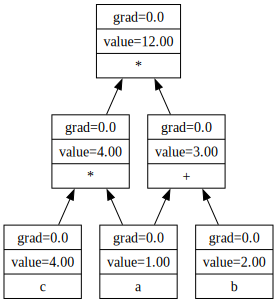

In [50]:
draw_graph(f)

In [51]:
# 拓扑排序
def _top_order(root):
    # 深度优先搜索
    ordered, visited = [], set()
    def _add_prevs(node):
        if node not in visited:
            visited.add(node)
            for prev in node.prevs:
                _add_prevs(prev)
            ordered.append(node)
    _add_prevs(root)
    return ordered

In [52]:
_top_order(f)

[1.0 | None | a,
 2.0 | None | b,
 3.0 | + | (a) + b,
 4.0 | None | c,
 4.0 | * | (a) * c,
 12.0 | * | ((a) + b) * (a) * c]

In [73]:
def backward(root):
    # 定义顶点梯度
    root.grad = 1.0
    for node in reversed(_top_order(root)):
        for v in node.prevs:
            v.grad += node.grad * node.grad_wrt[v]
    return root

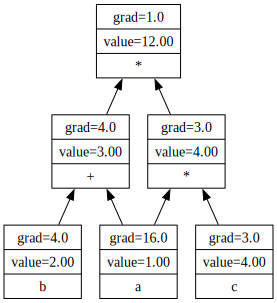

In [70]:
backward(f)
draw_graph(f)

上图中展示的是梯度传播的算法（最上面的节点是 $f$，$f$ 的左孩子是 $d$ 右孩子是 $e$），现在我来进行一个简单的推理，最终目标是要求出所有节点的梯度，而每个节点的梯度都依赖上一个节点的传播（链式求导），举个例子来说：

假设我要求 $a$ 节点的梯度，我们可以给出如下的表示：

$
\frac{\partial f}{\partial a} = \frac{\partial f}{\partial d} * \frac{\partial d}{\partial a} + \frac{\partial f}{\partial e} * \frac{\partial e}{\partial a}
$

要求 $a$ 对 $f$ 的求导，必须先知道 $d$ 对 $f$ 的求导，和 $e$ 对 $f$ 的求导。

我们已知：
$
\begin{cases}
f = d * e \\
e = a * c
\end{cases}
$

不难得出：

$
\begin{cases}
\frac{\partial f}{\partial d} = e = 4 \\
\frac{\partial f}{\partial e} = d = 3 \\
\frac{\partial d}{\partial a} = 1 \\
\frac{\partial e}{\partial a} = c = 4 \\
\end{cases}
$

另外，$f$ 对自己的导数是 1，不难得出，$a$ 的梯度为 $1 * 4 * 1 + 1 * 3 * 4 = 16$